Code to run model cross-validation (i.e. fit on 80% of data and test on remaining 20%).

In [3]:
%matplotlib inline
import os, glob, warnings, sys
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

import numpy as np
import pandas as pd
import scipy
from scipy import stats as ss
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import least_squares
from scipy.io import loadmat

sys.path.append('/project/3014018.02/analysis_mri/DataSharingCollection/Code/1.Behavior-FitModels/Functions/')
import choiceModels, costFunctions, penalizedModelFit

base_dir = '/project/3014018.02/analysis_mri/DataSharingCollection'

In [ ]:
import subprocess
subNums = np.array(pd.read_csv(os.path.join(base_dir,'Data/subjectsIncluded_batch1.csv'),header=None).T.append(
            pd.read_csv(os.path.join(base_dir,'Data/subjectsIncluded_batch2.csv'),header=None).T)).T[0]
print subNums
print len(np.unique(subNums))
niter = 1000
jobs_iterations = [2]
n_folds = 5
shuffle=True
for jobs_iteration in jobs_iterations:
    if os.path.isdir(os.path.join(base_dir,'Results/1.Behavior-FitModels/Iteration_%i'%jobs_iteration))==False:
        os.mkdir(os.path.join(base_dir,'Results/1.Behavior-FitModels/Iteration_%i'%jobs_iteration))
    jobids = pd.DataFrame(columns=['sub','jobid'])
    for sub in subNums:
        if ~os.path.isfile(os.path.join(base_dir,
                    'Results/1.Behavior-FitModels/Iteration_%i/Results_sub-%03d_%i-folds.csv'%(
                        jobs_iteration,sub,n_folds))):
            cmd = ['/home/decision/jervbaa/.conda/envs/nltools_env/bin/python2.7',
                '/home/decision/jervbaa/Software/SubmitToCluster.py',
                '-length','5:00:00',
                '-memory','2GB',
                '-name','CVmodel_sub-%02d-%i'%(sub,jobs_iteration),
                '-logfiledir',os.path.join(base_dir,'Results/1.Behavior-FitModels/Logfiles/'),
                '-command','python2.7 %s/Code/1.Behavior-FitModels/Functions/crossValidateModel.py %i %i %i %i %s'%(
                    base_dir,sub,niter,jobs_iteration,n_folds,shuffle),
                ]
            out = subprocess.check_output(' '.join(cmd),shell=True)
            print out
            jobid = out[-27:-1]
            tmp = pd.DataFrame(columns=jobids.columns)
            tmp.loc[0,'sub'] = sub
            tmp.loc[0,'jobid'] = jobid
            jobids = jobids.append(tmp)
    jobids.to_csv(os.path.join(base_dir,'Results/1.Behavior-FitModels/Logfiles/jobids_%i-folds_iteration_%i.csv'%(
        n_folds,jobs_iteration)))

## Compute average MSE and R per subject across folds

In [4]:
subNums = np.array(pd.read_csv(os.path.join(base_dir,'Data/subjectsIncluded_batch1.csv'),header=None).T.append(
            pd.read_csv(os.path.join(base_dir,'Data/subjectsIncluded_batch2.csv'),header=None).T)).T[0]
n_folds = 5
iteration = 1
print subNums
print len(np.unique(subNums))

model = 'MP_ppSOE'
if model == 'MP_ppSOE':
    modelUse = choiceModels.MP_model_ppSOE
else:
    modelUse = 'needtospecify'
dat = pd.read_csv(os.path.join(base_dir,'Data/1.TaskBehavior/allDataLong.csv'),header=None,index_col=None)
dat.columns=['sub','inv','mult','ret','exp','fair','soc1','soc2']
dat = dat.loc[dat['inv']>0,:]

cv_results = pd.DataFrame(columns=['sub','SSE','MSE','r','rsq'])

for sub in subNums:
    results = pd.read_csv(os.path.join(base_dir,
                     'Results/1.Behavior-FitModels/Iteration_%i/Results_sub-%03d_%i-folds.csv'%(
                         iteration,sub,n_folds)),index_col=0)
    subDat = dat.loc[dat['sub']==sub,:].reset_index(drop=True)
    
    for i,row in results.iterrows():
        theta = row['theta']
        phi = row['phi']
        string = row['test'][1:-1]+' '
        trials = [int(s) for s in string.split() if s.isdigit()]
        for trial in trials:
            inv = subDat.loc[trial,'inv']
            mult = subDat.loc[trial,'mult']
            subDat.loc[trial,'pred'] = modelUse(inv,mult,0,theta,phi)
    
    SSE = np.sum(np.square(np.array(subDat['ret'])-np.array(subDat['pred'])))
    MSE = SSE/len(subDat)
    r = scipy.stats.pearsonr(subDat['ret'],subDat['pred'])[0]
    r2 = r**2
    cv_results = cv_results.append(pd.DataFrame([[sub,SSE,MSE,r,r2]],columns=cv_results.columns))
# Note: SSE != SSE2! SSE2 is SSE on held-out data, SSE is SSE on training data.

[124 126 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 148 150 151 152 153 154 156 157 158 159 160 161 162 164 165
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 189
 190 191 192]
57


/home/decision/jervbaa/.conda/envs/hmtg_fmri_nc/lib/python2.7/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [5]:
cv_results.head()

,sub,SSE,MSE,r,rsq
0,124,83.0,1.092105,0.955983,0.913903
0,126,259.0,3.407895,0.953970,0.910059
0,128,255.0,3.355263,0.976844,0.954224
0,129,229.0,3.013158,0.962628,0.926653
0,130,473.0,6.223684,0.917563,0.841923


In [15]:
cv_results.reset_index(drop=True).to_csv(os.path.join(base_dir,
              'Results/1.Behavior-FitModels/CV_k-folds_true_results.csv'))

In [6]:
trueMSE = np.mean(cv_results['MSE'])
print trueMSE

5.37096029547553


Text(0.5,1,'Model fit on held-out data')

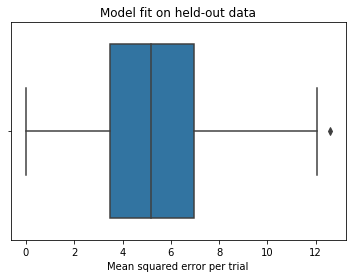

In [17]:
sns.boxplot(cv_results['MSE'])
plt.xlabel('Mean squared error per trial')
plt.title('Model fit on held-out data')

Text(0.5,1,'Model fit on held-out data')

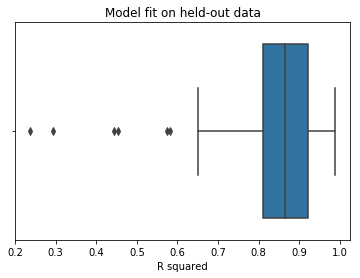

In [18]:
sns.boxplot(cv_results['rsq'])
plt.xlabel('R squared')
plt.title('Model fit on held-out data')

In [19]:
cv_results['rsq'].describe()

count    56.000000
mean      0.826737
std       0.159551
min       0.237713
25%       0.810419
50%       0.864233
75%       0.923208
max       0.988054
Name: rsq, dtype: float64

In [20]:
np.median(cv_results.loc[~np.isnan(cv_results['rsq']),'rsq'],)

0.8642327248333666

## Stats

In [21]:
scipy.stats.ttest_1samp(cv_results['r'],0,nan_policy='omit')

Ttest_1sampResult(statistic=66.14769411618579, pvalue=4.1198189957816575e-54)

In [22]:
sum(~np.isnan(cv_results['r']))

56